**Copyright 2019  Deepmind Technologies Limited. All Rights Reserved.**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
See the License for the specific language governing permissions and
limitations under the License.

# IODINE Interactive Evaluation
This notebook can load checkpoints and run the model.
You need to download the data before you can run this (see README.md).
It includes several plots to inspect the decomposition, iterations, and inputs to the refinement network, as well as prior samples, latent traversals and code to run on a custom example.


In [1]:
import numpy as np
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from absl import logging

# Ignore all tensorflow deprecation warnings 
logging._warn_preinit_stderr = 0
warnings.filterwarnings('ignore', module='.*tensorflow.*')
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sonnet as snt
from shapeguard import ShapeGuard
import seaborn as sns
import matplotlib.pyplot as plt

from main import ex, load_checkpoint,  build, get_train_step
from iodine.modules import plotting, utils

sns.set_style('whitegrid')

In [2]:
# Adjust this to load checkpoints for different datasets
configuration = 'clevr6'
#configuration = 'multi_dsprites'
#configuration = 'tetrominoes'

# Configuration values to adjust
config_updates = {
    'batch_size':1,               # to speed up interactive evaluation
    'data.shuffle_buffer': None,  # to speed up interactive evaluation
    # 'num_components':4,  # uncomment to change the number of components
    # 'num_iters': 5,      # uncomment to change the number of iterations
}

In [3]:
sess = tf.InteractiveSession()

# create a sacred run
r = ex._create_run(named_configs=[configuration], config_updates=config_updates, options={'--force': True, '--unobserved': True})

# restore the checkpoint and get the model, data, etc.
restored = load_checkpoint(session=sess)
model = restored["model"]
info = restored["info"]
dataset = restored["dataset"]
inputs = restored["inputs"]

Successfully restored Checkpoint "checkpoints/clevr6/model.ckpt"
Variable                                                 Shape      Type     Collections                            Device
encoder_net/cnn/conv_net_2d/conv_2d_0/b                  64         float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_0/w                  3x3x18x64  float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_1/b                  64         float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_1/w                  3x3x64x64  float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_2/b                  64         float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_2/w                  3x3x64x64  float32  global_variables, trainable_variables  (legacy)
encoder_net/cnn/conv_net_2d/conv_2d_3/b                  64   

In [4]:
# run evaluation and get the info dict
rinfo = sess.run(info)

# Decomposition
Let's plot the decomposition at the last timestep.
Set `mask_components=False` to see the full reconstruction for each component

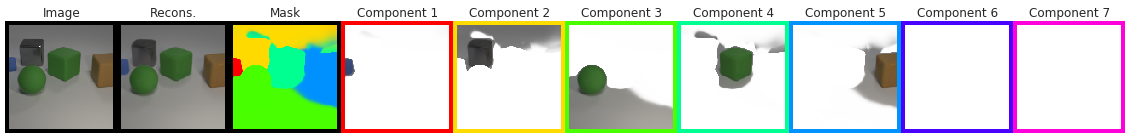

In [5]:
fig = plotting.example_plot(rinfo, t=-1, mask_components=True)

# Iterations
This plots the decompositions for all timesteps and an additional row with the ground truth segmentation, as well as the predicted mask-logits.

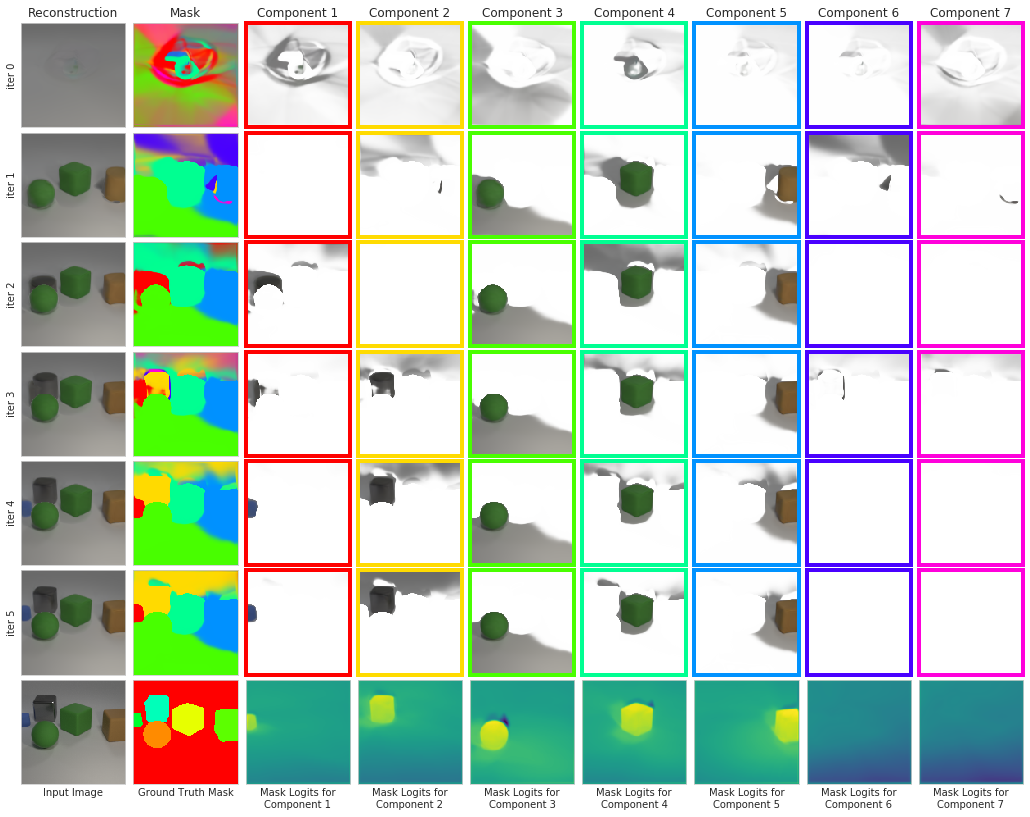

In [6]:
fig = plotting.iterations_plot(rinfo, mask_components=True)

We can also plot error and metrics over iterations to see how they improve over the refinement steps:

Errors and metrics over iterations


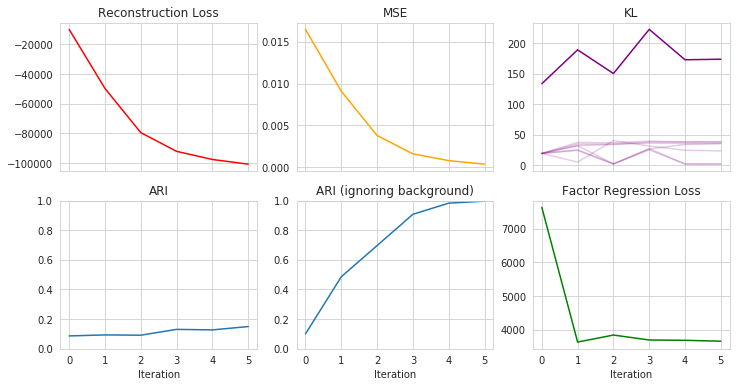

In [7]:
b = 0  # sample index inside batch

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(12, 6))

axes[0, 0].plot(rinfo["losses"]["recons"][b], color='r')
axes[0, 0].set_title("Reconstruction Loss")

axes[0, 1].plot(rinfo["metrics"]["mse"][b], color='orange')
axes[0, 1].set_title("MSE")

# Plot total KL and faintly also the individual object KLs
axes[0, 2].plot(rinfo["losses"]["kl"][b].sum(axis=1), color='purple')
axes[0, 2].plot(rinfo["losses"]["kl"][b], color='purple', alpha=0.2)
axes[0, 2].set_title("KL")

axes[1, 0].plot(rinfo["metrics"]["ari"][b])
axes[1, 0].set_title("ARI")
axes[1, 0].set_ylim((0, 1))
axes[1, 0].set_xlabel('Iteration')

axes[1, 1].plot(rinfo["metrics"]["ari_nobg"][b])
axes[1, 1].set_title("ARI (ignoring background)")
axes[1, 1].set_ylim((0, 1))
axes[1, 1].set_xlabel('Iteration')

axes[1, 2].plot(rinfo["losses"]["factor"], color='g')
axes[1, 2].set_title("Factor Regression Loss")
axes[1, 2].set_xlabel('Iteration')

print("Errors and metrics over iterations")

# Inputs to the Refinement Network
This plots all the spatial inputs that are being fed to the refinement network for a given timestep.

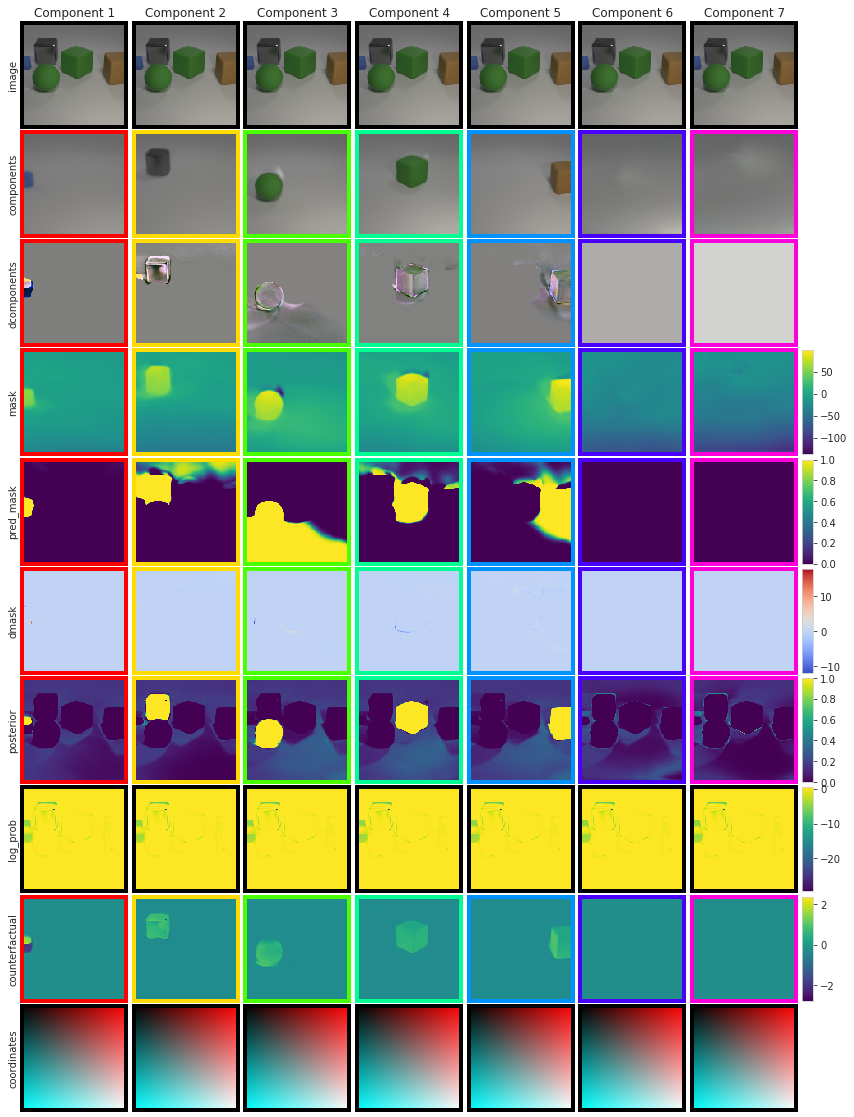

In [8]:
fig = plotting.inputs_plot(rinfo, t=-1)

# Latent Traversal

In [11]:
sg = ShapeGuard()
_ = sg.guard(rinfo['latent']['z'], "B, T, K, Z")
z_placeholder = tf.placeholder(tf.float32, shape=sg["B, K, Z"])
params, out_dist = model.decode(z_placeholder)
img = out_dist.mean()
highest_kl_obj_idx = rinfo['losses']['kl'][b, -1].argmax()

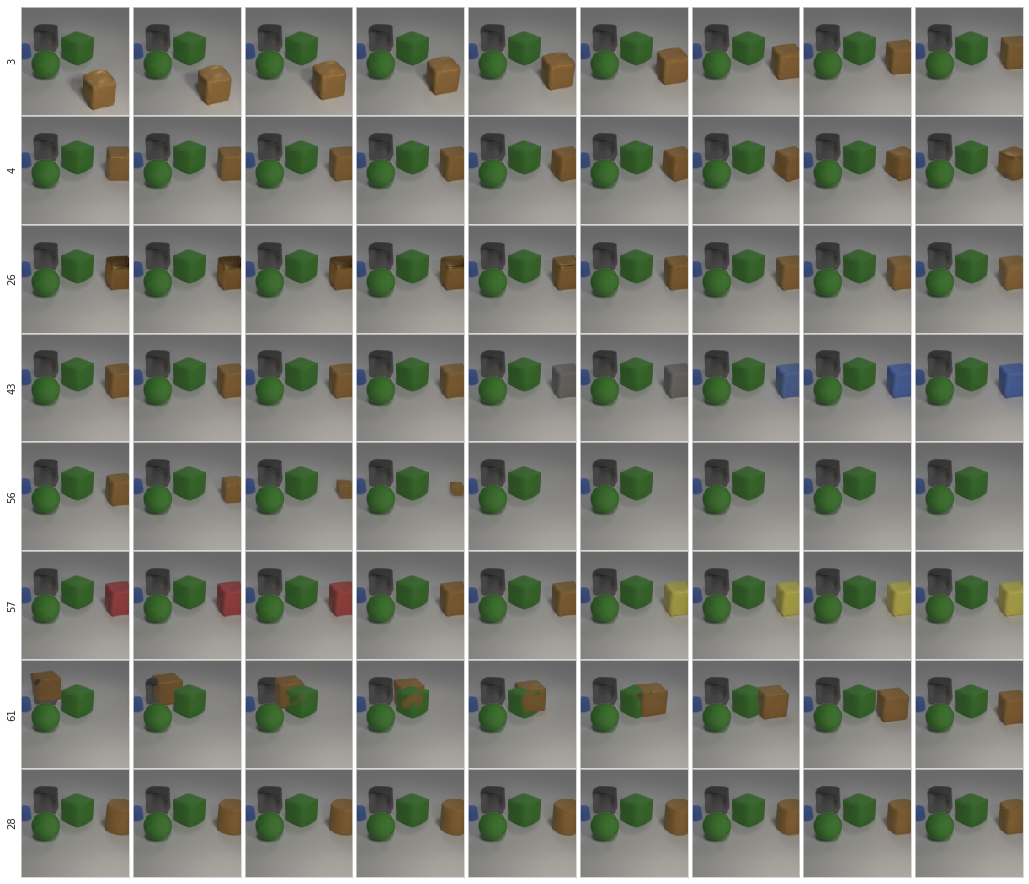

In [13]:
b = 0
obj_idx = highest_kl_obj_idx
interesting_latents = [3, 4, 26, 43, 56, 57, 61, 28]


fig, axes = plt.subplots(nrows=len(interesting_latents), ncols=9, sharex=True, sharey=True, figsize=(18, len(interesting_latents)*2))
for row, lat in enumerate(interesting_latents):
    z_adjusted = rinfo['latent']['z'][b:b+1, -1].copy()
    for col, val in enumerate(np.linspace(-1.25, 1.25, 9)):
        z_adjusted[b, obj_idx, lat] = val
        rimg = sess.run(img, feed_dict={z_placeholder:z_adjusted})
        plotting.show_img(rimg[0, 0], ax=axes[row, col])
    axes[row, 0].set_ylabel(lat)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

# Prior-samples
We can also sample a few `z` from the prior and decode them.

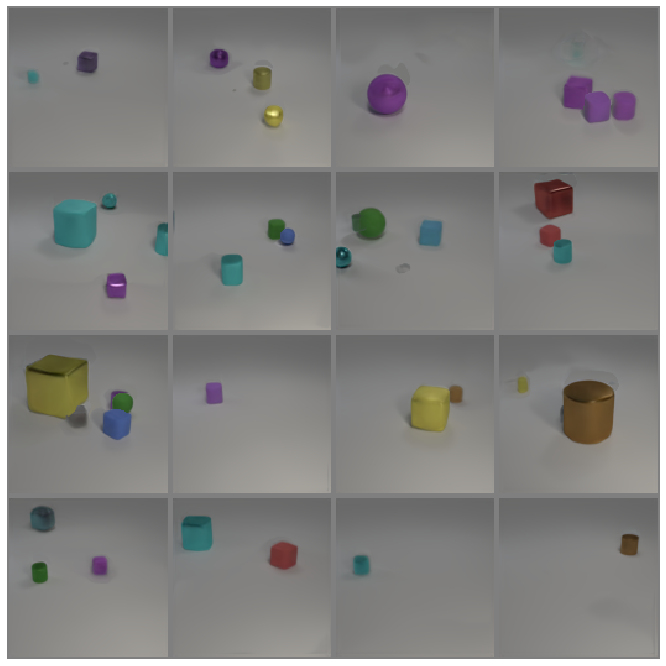

In [8]:
samples = model.get_sample_images()
rsamples = sess.run(samples)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(rsamples[0])
_ = ax.axis('off')

# Running on a custom image
To run IODINE on a custom image we need a set of placeholders. Then we can just evaluate it as usual:

In [9]:
# Get a set of placeholders for the dataset and evaluate the model using that
input_ph = dataset.get_placeholders()
custom_info = model.eval(input_ph)

In [10]:
# Construct zero-valued fillers for all placeholders
sg = ShapeGuard()
sg.guard(input_ph['image'], "B, 1, H, W, C")
sg.guard(input_ph['mask'], "B, 1, L, H, W, 1")
         
fillers = {
    input_ph['image']: np.zeros(sg['1, 1, H, W, C']),
    input_ph['mask']: np.zeros(sg['1, 1, L, H, W, 1']),
    input_ph['latent']['color']: np.zeros(sg["1, L, 1"]),
    input_ph['latent']['shape']: np.zeros(sg["1, L, 1"]),
    input_ph['latent']['size']: np.zeros(sg["1, L, 1"]),
    input_ph['latent']['position']: np.zeros(sg["1, L, 3"]),
    input_ph['latent']['rotation']: np.zeros(sg["1, L, 1"]),
    input_ph['visibility']: np.zeros(sg["1, L"]),
}

Now we can evaluate the model on any custom image like this real-world replica of the CLEVR dataset

![Realworld CLEVR](images/realworld_clevr.png)

(From ["Neural-Symbolic VQA: Disentangling Reasoning from Vision and Language Understanding"](https://www.semanticscholar.org/paper/Neural-Symbolic-VQA%3A-Disentangling-Reasoning-from-Yi-Wu/9d15ebe3f5aaf32a9f835f88703241461324c35b/figure/16) Kexin Yi, Jiajun Wu, Chuang Gan, Antonio Torralba, Pushmeet Kohli, Joshua B. Tenenbaum)




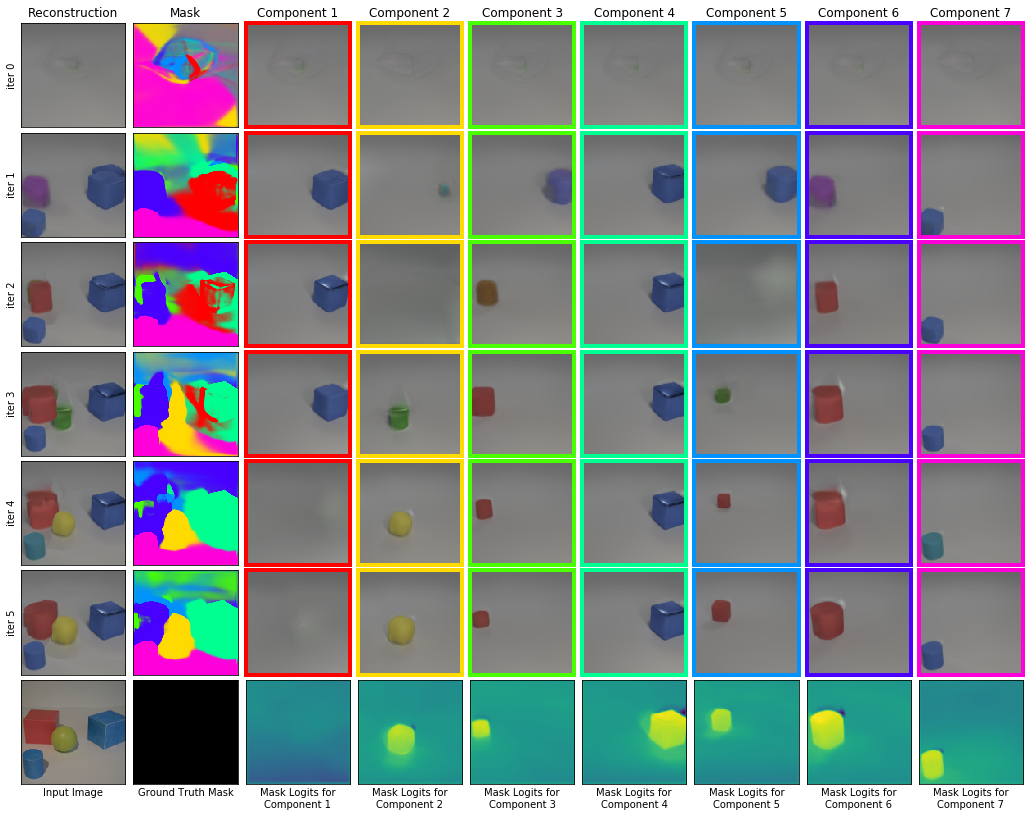

In [11]:
img = np.array(Image.open('images/realworld_clevr.png')) / 255.
fillers[input_ph['image']] = img.reshape(sg['1, 1, H, W, C'])
custom_rinfo = sess.run(custom_info, feed_dict=fillers)
fig = plotting.iterations_plot(custom_rinfo)

# Getting detailed information
The info returned by `model.eval()` contains many variables from all components and iterations.
For a rough overview see the following sketch:

![Overview of Variables](images/code_overview.svg)


<!--details><summary> info (click to exand) </summary-->
Dimensions:

* `B`: batch-size
* `T`: number of iterations + 1
* `K`: number of components
* `L`: maximum number of ground-truth objects
* `H`: image height
* `W`: image width
* `C`: image channels (usually 3 for RGB)
* `Z`: size of latent representation

Content of `info`:
    
* data: Inputs from the dataset (for the CLEVR dataset)
    * image: `(B, 1, H, W, C)` Input Image (For sequential data this has dimension `(B, T, H, W, C)`)
    * true_mask: `(B, 1, L, H, W, 1)`  ground truth mask (used for ARI and factor regressor only)
    * visibility: `(B, L)`  How many object are in this scene
    * factors: Information about true factors (used to train the factor regressor)
        * color: `(B, L, 1)`    The color of each object (categorical 9 choices)
        * position: `(B, L, 3)` The position of each object (x, y, z)
        * shape: `(B, L, 1)`    The shape of each object (categorical 4 choices)
        * size: `(B, L, 1)`     The size of each object (categorical 3 choices)
*  inputs:  Inputs to the refinement network
    * flat:
        * dzp: `(B, T, K, 2*Z)`
        * flat_capacity: `(B, T, K, 1)`
        * zp: `(B, T, K, 2*Z)`
    * spatial:
        * capacity: `(B, T, K, H, W, 1)`
        * components: `(B, T, K, H, W, C)`
        * coordinates: `(B, T, 1, H, W, 2)`
        * counterfactual: `(B, T, K, H, W, 1)`
        * dcomponents: `(B, T, K, H, W, C)`
        * dmask: `(B, T, K, H, W, 1)`
        * image: `(B, T, 1, H, W, C)`
        * log_prob: `(B, T, 1, H, W, 1)`
        * posterior: `(B, T, K, H, W, 1)`
        * pred_mask: `(B, T, K, H, W, 1)`
        * pred_mask_logits: `(B, T, K, H, W, 1)`
* latent: 
    * z: `(B, T, K, Z)`
    * z_mean: `(B, T, K, Z)`
    * z_stddev: `(B, T, K, Z)`
* outputs: Output of the decoder network
    * components: `(B, T, K, H, W, C)` Predicted means for each component.
    * pred_mask: `(B, T, K, H, W, 1)`  Predicted mask
    * pred_mask_logits: `(B, T, K, H, W, 1)` Predicted mask logits (pre-softmax) for each component
    * recons: `(B, T, 1, H, W, C)` image reconstruction (mean of the spatial mixture)
* losses:
    * total: float
    * recons: `(B, T)`
    * kl: `(B, T, K)`
    * factor: `(T,)`
* metrics
     * ari: `(B, T)`
     * kl: `(B, T, K)`
     * mse: `(B, T)`
* factor_regressor
  * assignment: `(B, T, L, K)`
  * predictions: 
    * color: `(B, T, L, 9)`
    * position: `(B, T, L, 3)`
    * shape: `(B, T, L, 4)`
    * size: `(B, T, L, 3)`
  * metrics:
    * color: `(T,)`    Color prediction accuracy
    * shape: `(T,)`    Shape prediction accuracy
    * size: `(T,)`     Size prediction accuracy
    * position: `(T,)` R^2 metric for position prediction
<!-- </details> -->

In [10]:
utils.print_shapes('out_info', info)

out_info:
  data:
    image: [1, 1, 128, 128, 3] @ <dtype: 'float32'>
    true_mask: [1, 1, 11, 128, 128, 1] @ <dtype: 'float32'>
    visibility: [1, 11] @ <dtype: 'float32'>
    factors:
      color: [1, 11, 1] @ <dtype: 'uint8'>
      position: [1, 11, 3] @ <dtype: 'float32'>
      rotation: [1, 11, 1] @ <dtype: 'float32'>
      shape: [1, 11, 1] @ <dtype: 'uint8'>
      size: [1, 11, 1] @ <dtype: 'uint8'>
  factor_regressor:
    assignment: [1, 6, 11, 7] @ <dtype: 'float32'>
    metrics:
      color: [6] @ <dtype: 'float32'>
      position: [6] @ <dtype: 'float32'>
      shape: [6] @ <dtype: 'float32'>
      size: [6] @ <dtype: 'float32'>
    predictions:
      color: [1, 6, 11, 9] @ <dtype: 'float32'>
      position: [1, 6, 11, 3] @ <dtype: 'float32'>
      shape: [1, 6, 11, 4] @ <dtype: 'float32'>
      size: [1, 6, 11, 3] @ <dtype: 'float32'>
  inputs:
    flat:
      dzp: [1, 6, 7, 128] @ <dtype: 'float32'>
      flat_capacity: [1, 6, 7, 1] @ <dtype: 'float32'>
      zp: [1, 6, 